## Предсказание стоимости жилья

В проекте вам нужно обучить модель линейной регрессии на данных о жилье в Калифорнии в 1990 году. На основе данных нужно предсказать медианную стоимость дома в жилом массиве. Обучите модель и сделайте предсказания на тестовой выборке. Для оценки качества модели используйте метрики RMSE, MAE и R2.

# Подготовка данных

Загрузим необходимые библиоткеи, которые нам пригодятся в работе с проектом

In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pyspark
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.window import Window 
from pyspark.sql.types import *

from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, OneHotEncoder
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

In [2]:
# здесь объявим используемые константы
train_size = .8
test_size = .2
RANDOM_SEED = 2025

In [3]:
# создавние класса для стилизации вывода с помощью команды print()
class color:
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

In [4]:
# инициализация Spark-сессии
spark = SparkSession.builder \
                    .master('local') \
                    .appName('California housing') \
                    .getOrCreate()

In [5]:
# загрузка данных
df_housing = spark.read.load('/datasets/housing.csv', format='csv', sep=',', inferSchema=True, header=True)

In [6]:
# проверка типов данных колонок и их названий
df_housing.printSchema()
df_housing.show(n=5)

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR B

В колонках датасета содержатся следующие данные:
* **longitude** — широта;
* **latitude** — долгота;
* **housing_median_age** — медианный возраст жителей жилого массива;
* **total_rooms** — общее количество комнат в домах жилого массива;
* **total_bedrooms** — общее количество спален в домах жилого массива;
* **population** — количество человек, которые проживают в жилом массиве;
* **households** — количество домовладений в жилом массиве;
* **median_income** — медианный доход жителей жилого массива;
* **median_house_value** — медианная стоимость дома в жилом массиве;
* **ocean_proximity** — близость к океану.

In [7]:
df_housing.describe().toPandas()

,summary,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,count,20640,20640,20640,20640,20433,20640,20640,20640,20640,20640
1,mean,-119.56970445736148,35.6318614341087,28.639486434108527,2635.7630813953488,537.8705525375618,1425.4767441860465,499.5396802325581,3.8706710029070246,206855.81690891474,None
2,stddev,2.003531723502584,2.135952397457101,12.58555761211163,2181.6152515827944,421.38507007403115,1132.46212176534,382.3297528316098,1.899821717945263,115395.61587441359,None
3,min,-124.35,32.54,1.0,2.0,1.0,3.0,1.0,0.4999,14999.0,<1H OCEAN
4,max,-114.31,41.95,52.0,39320.0,6445.0,35682.0,6082.0,15.0001,500001.0,NEAR OCEAN


In [8]:
# Проверка пропусков в данных
print("Проверка наличия пропусков в данных:")
missing_counts = df_housing.select([(F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c)) for c in df_housing.columns])
missing_counts.show()

Проверка наличия пропусков в данных:
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|        0|       0|                 0|          0|           207|         0|         0|            0|                 0|              0|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+



Пропуски обнаружены только в признаке с количеством спальных комнат жилом массиве. Можно заметить что спален зачастую немного больше, чем самих домовладений. Поскольку пропусков в данных с количеством домовладений 

In [9]:
groupedByOcean_proximity = df_housing.filter(df_housing["total_bedrooms"].isNotNull()) \
                                     .select((F.col('total_bedrooms') / F.col('households')).alias('ratio'),
                                             'ocean_proximity').groupBy('ocean_proximity').agg(F.mean('ratio').alias('mean_bedrooms_ratio'))
groupedByOcean_proximity.show()

+---------------+-------------------+
|ocean_proximity|mean_bedrooms_ratio|
+---------------+-------------------+
|         ISLAND| 1.5220039645390089|
|     NEAR OCEAN| 1.0744579500247342|
|       NEAR BAY| 1.0531221087345055|
|      <1H OCEAN| 1.0497346524932645|
|         INLAND| 1.1870535990232673|
+---------------+-------------------+



In [10]:
df_housing = df_housing.join(groupedByOcean_proximity, on='ocean_proximity', how="left")

In [11]:
df_filled = df_housing.withColumn('total_bedrooms',
                                   F.when(
                                       df_housing["total_bedrooms"].isNull() | F.isnan('total_bedrooms'),
                                       df_housing['mean_bedrooms_ratio'] * df_housing["households"]
                                   ).otherwise(df_housing['total_bedrooms'])
                                  )

In [12]:
# удалим вспомогательную колонку, которая создавалась для заполнения пропусков
df_filled = df_filled.drop('mean_bedrooms_ratio')

In [13]:
# проверка пропусков после заполнения
missing_counts = df_filled.select([(F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c)) for c in df_filled.columns])
missing_counts.show()

+---------------+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|ocean_proximity|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|
+---------------+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+
|              0|        0|       0|                 0|          0|             0|         0|         0|            0|                 0|
+---------------+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+



Создадим дополнительные описательные признаки, которые могут помочь нам в предсказании целевого 

In [14]:
# rooms_per_household - отношение количества комнат к количеству домовладений
# population_in_household - отношение количества жителей к количеству домовладений 
# bedroom_index - отношение количества спален к общему количеству комнат 

df_filled = df_filled.withColumn('rooms_per_household', F.col('total_rooms') / F.col('households')) \
                     .withColumn('population_in_household', F.col('population') / F.col('households')) \
                     .withColumn('bedroom_index', F.col('total_bedrooms') / F.col('total_rooms'))

# Обучение моделей

In [15]:
df = df_filled

In [16]:
df.limit(5).toPandas()

,ocean_proximity,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,population_in_household,bedroom_index
0,NEAR BAY,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,6.984127,2.555556,0.146591
1,NEAR BAY,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,6.238137,2.109842,0.155797
2,NEAR BAY,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,8.288136,2.802260,0.129516
3,NEAR BAY,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,5.817352,2.547945,0.184458
4,NEAR BAY,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,6.281853,2.181467,0.172096


Для создания и обучения моделей нам потребуется несколько выборок признаков. Конкретно в данной задаче требуется построить две модели линейной регрессии на разных наборах данных:
 * используя все данные из файла;
 * используя только числовые переменные, исключив категориальные.

In [17]:
def pySparkLinearRegression(data, target_col, condtiton=False, threshold=None):
    print('Количество строк в переданом датасете:', data.count())
    # разделяем колонки по типу
    # я заранее знаю какой тип данных содержится в данных, поэтому не буду усложнять код
    categorical_cols = [field.name for field in data.schema.fields if field.dataType == StringType()
                                                                   and field.name != target_col]

    numeric_cols = [field.name for field in data.schema.fields if field.dataType == DoubleType() 
                                                            and field.name != target_col]
    # в проекте стоит задача посмотреть как будет работать модель без категориальых признаков,
    # поэтому добавяляю такое условие
    
    # разделяю на обучающую и тестовую выборку 
    train_data, test_data = data.randomSplit([train_size, test_size], seed=RANDOM_SEED)
    print('Количество строк в тренировочных данных:', train_data.count())
    print('Количество строк в тестовых данных:', test_data.count(), end='\n')

    # снова определю названия генерируемых колонок
    indexed_cols = [c+'_idx' for c in categorical_cols]
    encoded_ohe_cols = [c+'_ohe' for c in indexed_cols]

    if condtiton:
        train_data = train_data.filter(df[target_col] < threshold)

    fitting_train_data = train_data
    
    if len(categorical_cols) > 0:
        # снова определю названия генерируемых колонок
        indexed_cols = [c+'_idx' for c in categorical_cols]
        encoded_ohe_cols = [c+'_ohe' for c in indexed_cols]
        # объявляю трансформеры
        indexer = StringIndexer(inputCols=categorical_cols, 
                                outputCols=indexed_cols, handleInvalid = 'keep') 
        encoder = OneHotEncoder(inputCols=indexed_cols,
                                outputCols=encoded_ohe_cols)
        # выполняю обучение трансформеров на тренировочной выборке 
        # и преобразования на тренировочной и тестовой выборке
        
        train_data_idx = indexer.fit(fitting_train_data).transform(train_data)        
        train_data = encoder.fit(train_data_idx).transform(train_data_idx)

        test_data = indexer.fit(fitting_train_data).transform(test_data)
        test_data = encoder.fit(train_data_idx).transform(test_data)
        
        # опять же, учитывая тот факт что в текущих данных только один столбец категориальный
        # я не трансформирую результат работы OHE в единый вектор
        # на других данных будет по-другому
    else:
        encoded_ohe_cols = []
        
    # масштабирую числовые признаки
    numerical_assembler = VectorAssembler(inputCols=numeric_cols,
                                          outputCol='numerical_features')
    standardScaler = StandardScaler(inputCol='numerical_features',
                                    outputCol='numerical_features_scaled')

    
    train_data = numerical_assembler.transform(train_data)
    fitting_num_assembler = numerical_assembler.transform(fitting_train_data)
    train_data = standardScaler.fit(fitting_num_assembler).transform(train_data)

    
    test_data = numerical_assembler.transform(test_data)
    test_data = standardScaler.fit(fitting_num_assembler).transform(test_data)

    # соединяю полученные признаки numerical_features_scaled и результат работы OHE
    assembler_all_features = VectorAssembler(inputCols=['numerical_features_scaled'] + encoded_ohe_cols, 
                                      outputCol='all_features') 
    train_data = assembler_all_features.transform(train_data)
    test_data = assembler_all_features.transform(test_data)

    # объявляю модель линейной регрессии и выполняю предсказания
    lr = LinearRegression(labelCol=target_col, featuresCol='all_features')
    model = lr.fit(train_data)
        
    predictions = model.transform(test_data)
    predictedLabes = predictions.select(target_col, 'prediction')

    n = 6
    print(f'Первые {n} строк предсказаний модели')
    predictedLabes.show(n=n)

    # объявляю трансформер RegressionEvaluator для оценки результатов работы модели
    evaluator = RegressionEvaluator(labelCol=target_col, predictionCol='prediction')

    print(f"{color.UNDERLINE + color.BLUE}Результат работы модели линейной регрессии на переданном наборе данных{color.END}")
    for metric in ['rmse', 'mae', 'r2']:
        mtrc = evaluator.evaluate(predictedLabes, {evaluator.metricName: metric})
        print(f"{color.BOLD}{metric}{color.END}: {mtrc}")
    print()    
    return predictions
    # результатом работы функции является датафрейм 

In [18]:
predictions_all_features = pySparkLinearRegression(df, 'median_house_value')

Количество строк в переданом датасете: 20640


Количество строк в тренировочных данных: 16454


Количество строк в тестовых данных: 4186


25/01/16 06:34:23 WARN Instrumentation: [6365e1cf] regParam is zero, which might cause numerical instability and overfitting.
25/01/16 06:34:24 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
25/01/16 06:34:24 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
25/01/16 06:34:25 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
25/01/16 06:34:25 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK
25/01/16 06:34:25 WARN Instrumentation: [6365e1cf] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Первые 6 строк предсказаний модели


+------------------+------------------+
|median_house_value|        prediction|
+------------------+------------------+
|           94800.0|186836.33570089843|
|           57500.0|151750.05115251476|
|           84200.0|170546.49368336145|
|           74000.0| 153614.8125858507|
|          113300.0|244489.56971330475|
|          101900.0|152018.96960673062|
+------------------+------------------+
only showing top 6 rows

Результат работы модели линейной регрессии на переданном наборе данных


rmse: 70273.10203600384


mae: 50267.52559644155


r2: 0.6365076510934691



In [19]:
predictions_only_num = pySparkLinearRegression(df.drop('ocean_proximity'), 'median_house_value')

Количество строк в переданом датасете: 20640


Количество строк в тренировочных данных: 16454


Количество строк в тестовых данных: 4186


25/01/16 06:35:10 WARN Instrumentation: [c04a3d22] regParam is zero, which might cause numerical instability and overfitting.


Первые 6 строк предсказаний модели


+------------------+------------------+
|median_house_value|        prediction|
+------------------+------------------+
|          103600.0| 99582.79694050411|
|          106700.0| 184605.3095610356|
|          107000.0| 154466.6043343991|
|          116100.0|196020.47664011922|
|           85600.0|153113.04914060095|
|           81800.0|198753.76331447158|
+------------------+------------------+
only showing top 6 rows

Результат работы модели линейной регрессии на переданном наборе данных


rmse: 70112.0427882378


mae: 50529.20093371395


r2: 0.6321304182630831



In [20]:
predictions_without_geo = pySparkLinearRegression(df.drop('longitude', 'latitude'), 'median_house_value')

Количество строк в переданом датасете: 20640


Количество строк в тренировочных данных: 16454


Количество строк в тестовых данных: 4186


25/01/16 06:35:45 WARN Instrumentation: [bf4f5eb3] regParam is zero, which might cause numerical instability and overfitting.
25/01/16 06:35:46 WARN Instrumentation: [bf4f5eb3] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Первые 6 строк предсказаний модели


+------------------+------------------+
|median_house_value|        prediction|
+------------------+------------------+
|          500001.0| 359550.6544088693|
|          298500.0| 308152.5984934175|
|          187300.0|266066.74277713103|
|          225600.0|244932.41361579072|
|          358000.0| 324219.4933093778|
|          291300.0|357252.92596082756|
+------------------+------------------+
only showing top 6 rows

Результат работы модели линейной регрессии на переданном наборе данных


rmse: 71586.20958407891


mae: 50505.83876352337


r2: 0.6204960921594154



In [21]:
spark.sparkContext.setLogLevel("ERROR")

In [22]:
predictions_without_sintetic_features = pySparkLinearRegression(df.drop('rooms_per_household',
                                                                        'population_in_household',
                                                                        'bedroom_index'), 
                                                                'median_house_value')

Количество строк в переданом датасете: 20640


Количество строк в тренировочных данных: 16454


Количество строк в тестовых данных: 4186


25/01/16 06:36:13 ERROR LBFGS: Failure! Resetting history: breeze.optimize.FirstOrderException: Line search zoom failed
25/01/16 06:36:13 ERROR LBFGS: Failure! Resetting history: breeze.optimize.FirstOrderException: Line search zoom failed
25/01/16 06:36:13 ERROR LBFGS: Failure again! Giving up and returning. Maybe the objective is just poorly behaved?


Первые 6 строк предсказаний модели


+------------------+------------------+
|median_house_value|        prediction|
+------------------+------------------+
|           94800.0|197069.12158893887|
|           57500.0| 156577.2580533363|
|           84200.0|175167.03151839413|
|           74000.0|161553.75368398894|
|          113300.0|  246804.949959883|
|          101900.0|154533.61936795013|
+------------------+------------------+
only showing top 6 rows

Результат работы модели линейной регрессии на переданном наборе данных


rmse: 70686.15543575787


mae: 50911.39628300817


r2: 0.6322219998261626



# Анализ результатов

Наилучшие результаты выдает модель, обученная на всех признаках:
* rmse: 70112.04
* mae: 50529.20
* r2: 0.6321

Посмотрим на распределение данных, с которыми все это время работали.

In [22]:
dfs = df.sample(fraction=0.2, seed=RANDOM_SEED)

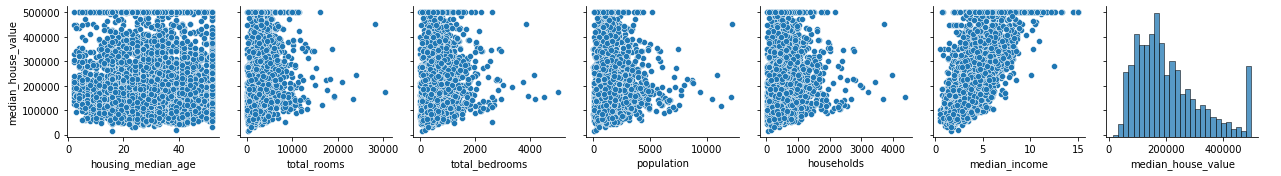

In [23]:
g = sns.PairGrid(data=dfs.select('housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households',
             'median_income', 'median_house_value').toPandas(), y_vars='median_house_value')
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()
plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


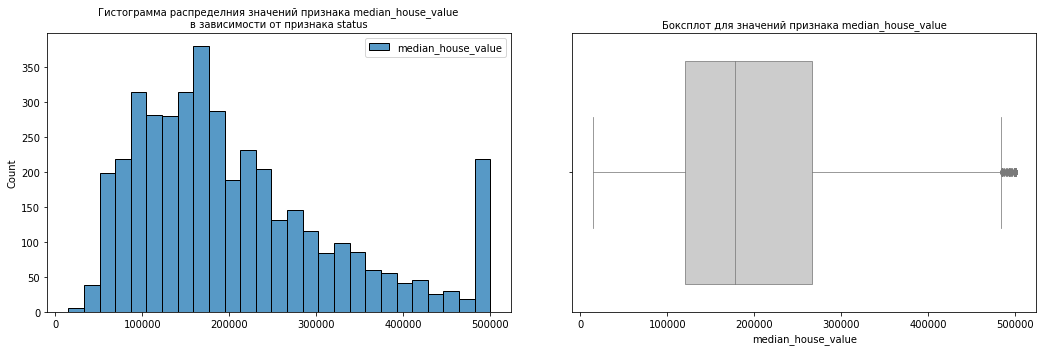

In [24]:
data = dfs.select('median_house_value').toPandas()

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.tight_layout(pad=3, h_pad=5)


sns.histplot(data, ax=axs[0])
sns.boxplot(data['median_house_value'], ax=axs[1], color=".8", linewidth=.75, orient='h')
axs[0].set_title(f'Гистограмма распределния значений признака {data.iloc[:, 0].name} \nв зависимости от признака status', fontsize=10)
axs[1].set_title(f'Боксплот для значений признака {data.iloc[:, 0].name}', fontsize=10)

plt.show()

Явной линейной зависимости тут не видно, также еще и очень много выбросов, а, как известно, линейная регрессиия к ним очень чувствительна. 

Скорее всего это отдельная категория домов cо стоимостью более 0,5 миллиона долларов. 

In [25]:
data_slice = df.filter(df['median_house_value'] > 500000).select('median_house_value')
data_slice.distinct().show()
print('Количество домов со стоимостью более 500.000$ -', data_slice.count(), 'штук')

+------------------+
|median_house_value|
+------------------+
|          500001.0|
+------------------+

Количество домов со стоимостью более 500.000$ - 965 штук


In [26]:
predictions = pySparkLinearRegression(df, 'median_house_value', condtiton=True, threshold=500000)

Количество строк в переданом датасете: 20640


Количество строк в тренировочных данных: 16454


Количество строк в тестовых данных: 4186


25/01/15 17:25:11 WARN Instrumentation: [7a1e73a7] regParam is zero, which might cause numerical instability and overfitting.
25/01/15 17:25:12 WARN Instrumentation: [7a1e73a7] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Первые 6 строк предсказаний модели


+------------------+------------------+
|median_house_value|        prediction|
+------------------+------------------+
|           94800.0| 184765.7037977809|
|           57500.0| 148879.2762837042|
|           84200.0|169239.79072831292|
|           74000.0|150361.67825375404|
|          113300.0|237536.40422972664|
|          101900.0| 149980.3830843172|
+------------------+------------------+
only showing top 6 rows

Результат работы модели линейной регрессии на переданном наборе данных


rmse: 70317.5184935265


mae: 49601.32200195898


r2: 0.6360480116501088



Скорее всего дело в распредлении самих данных и линейная модель тут не подойдет

RMSE и MAE не особо не уменишились, а увеличение R2 связано с уменьшением количества данных.

In [27]:
spark.stop()

## Вывод

В данной работе была проделана работа по результатам которой получена модель модель линейной регрессии, обученная на данных о жилье в Калифорнии в 1990 году. Наилучшие результаты rmse: 70112.04, mae: 50529.20, r2: 0.6321.

Результаты модели не утешительные, работает она не многим лучше, чем если бы предсказывала среднее значение. Связано это, скорее всего, с нелинейным распределением данных.